# CAI Lab Session 9: simulation of SI model of contagion over contact networks

In this session you will:

- learn about the `SI` epidemic model of contagion
- simulate `SI` epidemic spreading over different network topologies
- monitor fraction of infected nodes over time

## 1. The SI epidemic model

In classic epidemiology, it is assumed that every individual has an equal chance of coming into contact with every other individual in the population.
This is, however, highly unrealistic and we can improve on this assumption by simulating the spread of an infection over a realistic contact social network.
In such a network, nodes are individuals susceptible to becoming sick and edges correspond to their chance of making physical contact and thus getting infected.

The SI model is one of the most simple models used for studying infection and assumes that individuals can be in one of two states: _infected_, or _susceptible_ to infection (i.e. not infected yet). 
Initially, all individuals (or nodes) are susceptible and at time $t=0$ some node becomes infected (this node corresponds to _patient 0_). 
Over time, as nodes come into contact with other nodes, they may become infected too and can spread the disease further to their contacts and so on.

An important parameter of this model is the _infection rate_ $\alpha$ which is the probability that an infected node infects a neighbouring one after contact. 
Clearly, $0\leq\alpha\leq 1$ and the closer it is to 1 the faster the infection will spread. Additionally, the underlying topology of the contact network also 
plays a role in how the infection spreads and this is what you have to study in this session.


## 2. Simulating the SI epidemic model at discrete time steps

You will have to implement the simulation of the spreading of the SI model over diverse network topologies using discrete time steps. Thus, given a contact network $G$, we have that:

- at time $t = 0$ a random node becomes infected
- after each time step (that is, one infection round), each infected node potentially infects neighboring nodes independently with probability $\alpha$

You can use the `igraph` library from last session to help you with the generation of contact networks, managing of nodes' statuses, etc. 
Also, we will be using undirected graphs as contact networks.

The quantity of interest to monitor will be the fraction of infected nodes over time, which should grow over time since infected nodes never recover in this model.

>   _You should be careful when implementing your simulation; please make sure that the updates of the nodes’ statuses are done in parallel, that is, to update the status for time t only statuses of time t−1 of the other nodes are considered._


## 3. Functionality of `igraph` that may be of help

This library provides functions to generate networks, traverse them, assign attributes to nodes, and selecting nodes' neighborhoods. 
This is going to be highly useful for the implementation of the epidemic simulation. 
Below you can find some examples on how to do some of the things mentioned above; please consult [`igraph`'s documentation](https://python.igraph.org/en/stable/) for more detailed information.

#### graph generation:

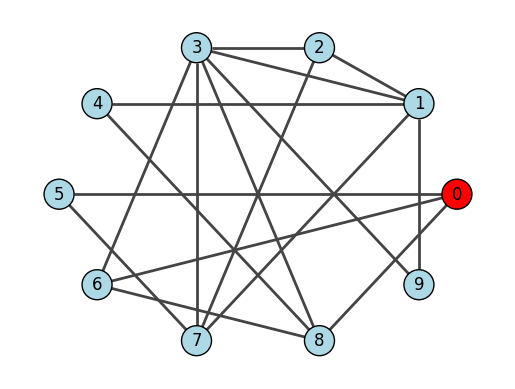

In [1]:
import igraph as ig
import matplotlib.pyplot as plt

# generating an ER graph with n=10 nodes and probability p=0.3 of adding edges between each pair of nodes
g = ig.Graph.Erdos_Renyi(10, 0.3)

# visualizing the generated graph
g.vs['color'] = 'lightblue'
g.vs[0]['color'] = 'red'

fig, ax = plt.subplots()
ig.plot(
    g,
    target=ax,
    vertex_size=30,
    vertex_label=range(g.vcount()),
    layout=g.layout("circle")
);

#### values and attributes of nodes:

In [2]:

# set value 'False' to attribute 'foo' for all nodes in graph g
g.vs['foo'] = False

# set value 'True' to attribute 'foo' for node 0
g.vs[0]['foo'] = True

# print node 0 attributes
print(g.vs[0].attributes())

# print node 0 value for attribute 'foo'
print(g.vs[0]['foo'])

# print all nodes' vales for attribute 'foo'
print(g.vs['foo'])




{'color': 'red', 'foo': True}
True
[True, False, False, False, False, False, False, False, False, False]


#### selecting nodes by attribute value:

In [3]:
nodes_subset = g.vs.select(foo=True)
for v in nodes_subset:
    print(v.index)
    print(v.attributes())

0
{'color': 'red', 'foo': True}


#### finding neighbors

In [4]:
nei = g.vs[0].neighbors()
for v in nei:
    print(v.index)
    print(v.attributes())

5
{'color': 'lightblue', 'foo': False}
6
{'color': 'lightblue', 'foo': False}
8
{'color': 'lightblue', 'foo': False}


## 4. Your tasks



Study evolution of infection over time for different topologies. Here, there are several things that you may play with (be creative!):

- underlying contact networks: you should consider at least the ones seen in class (Erdös-Rényii, Watts-Strogatz, and Barabasi-Albert) but there are others already implemented that may be of interest (Tree, Lattice, etc.)
- patient 0 selection: random selection, or select patient 0 with smallest/largest centrality, etc.
- infection rate: how does the infection rate affect speed of spreading for different topologies?

Things that may be of importance:

- graphs should be large enough (at least $n=1000$ nodes) so that interesting things may happen
- graphs should be _connected_ so that all nodes may be reachable by patient 0

In [5]:
import random
 
def select_initial_node(g, method): 
  if method == 1: # random
    return random.choice(g.vs).index
  if method == 2: # max degree
    return g.vs.degree().index(max(g.vs.degree()))
  if method == 3: # min degree
    return g.vs.degree().index(min(g.vs.degree()))
  if method == 4: # max betweenness
    return g.vs.betweenness().index(max(g.vs.betweenness()))
  if method == 5: # min betweenness
    return g.vs.betweenness().index(min(g.vs.betweenness()))
  if method == 6: # max closeness
    return g.vs.closeness().index(max(g.vs.closeness()))
  if method == 7: # min closeness
    return g.vs.closeness().index(min(g.vs.closeness()))


def spread(g, alpha, initial_node_method): 
  g.vs['infected'] = False
  
  initial_node = select_initial_node(g, initial_node_method)
  g.vs[initial_node]['infected'] = True
  
  steps = 0
  evolution = []
  stop_condition = 0
  
  while len(g.vs.select(infected=True)) < g.vcount() and stop_condition < 1000:
    infected = len(g.vs.select(infected=True)) 
    for v in g.vs.select(infected=True):
      for neighbor in v.neighbors():
        if neighbor['infected'] == False and random.random() < alpha:
          neighbor['infected'] = True
    
    if infected == len(g.vs.select(infected=True)):
      stop_condition += 1
    else:
      stop_condition = 0  
    
    steps += 1
    evolution.append(len(g.vs.select(infected=True)))
          
  return steps, evolution

In [12]:
n = 1000
m = 2000

In [13]:
connected = False
while not connected:
    g1 = ig.Graph.Erdos_Renyi(n, m=m)
    connected = g1.is_connected()

connected = False
while not connected:
    g2 = ig.Graph.Barabasi(n, m=(m//n))
    connected = g2.is_connected()
    
connected = False
while not connected:
    g3 = ig.Graph.Watts_Strogatz(1, n, m//n, 0.1)
    connected = g3.is_connected()

KeyboardInterrupt: 

In [10]:
alphas = [0.1, 0.3, 0.5, 0.7]
methods = [1, 2, 3, 4, 5, 6, 7]
graphs = [g1, g2, g3]

results = {}

for i, g in enumerate(graphs):
  for a in alphas:
    for method in methods:
      # print(i, a, method)
      results[(i, a, method)] = spread(g, a, method)

In [ ]:
import pandas as pd

df = pd.DataFrame.from_dict(results, orient='index')
df.reset_index(inplace=True)
df[['graph', 'alpha', 'method']] = pd.DataFrame(df['index'].tolist(), index=df.index)
df = df.drop(columns=['index'])
df = df.rename(columns={0: 'steps'})
df = df.rename(columns={1: 'evolution'})

method_names = {1: 'random', 
                2: 'max degree', 
                3: 'min degree', 
                4: 'max betweenness', 
                5: 'min betweenness', 
                6: 'max closeness', 
                7: 'min closeness'}

df['method'] = df['method'].map(method_names)
df.head()

,steps,evolution,graph,alpha,method
0,11,"[1, 1, 2, 4, 5, 5, 5, 5, 7, 7, 10]",0,0.1,random
1,15,"[1, 1, 1, 3, 4, 5, 7, 7, 8, 9, 9, 9, 9, 9, 10]",0,0.1,max degree
2,15,"[2, 2, 2, 2, 3, 3, 3, 3, 4, 5, 6, 7, 8, 9, 10]",0,0.1,min degree
3,10,"[2, 2, 3, 5, 6, 7, 9, 9, 9, 10]",0,0.1,max betweenness
4,18,"[1, 1, 1, 1, 1, 2, 3, 4, 5, 6, 6, 6, 7, 8, 9, ...",0,0.1,min betweenness


In [11]:
import altair as alt

def create_heatmap(df, graph):
  return alt.Chart(df[df['graph'] == graph]).mark_rect().encode(
    x = alt.X('alpha:O', title='Alpha', axis=alt.Axis(labelAngle=0)),
    y = alt.Y('method:O', title='Initial node selection method'),
    color = alt.Color('steps:Q', title='Steps')
  ).properties(
    width=500,
    height=300
  )

create_heatmap(df, 0) & create_heatmap(df, 1) & create_heatmap(df, 2)  

NameError: name 'df' is not defined

In [ ]:
import numpy as np
row = df.sample(1)
df1 = pd.DataFrame({'evolution': row['evolution'].values[0], 'steps': np.arange(1, len(row['evolution'].values[0])+1)})

In [ ]:
alt.Chart(df1).mark_line().encode(
  x = alt.X('steps:Q', title='Steps'),
  y = alt.Y('evolution:Q', title='Infected nodes')
).properties(
  width=500,
  height=300
)

alt.Chart(...)

## 5. Rules of delivery

- To be solved in _pairs_.

- No plagiarism; don't discuss your work with other teams. You can ask for help to others for simple things, such as recalling a python instruction or module, but nothing too specific to the session.

- If you feel you are spending much more time than the rest of the classmates, ask us for help. Questions can be asked either in person or by email, and you'll never be penalized by asking questions, no matter how stupid they look in retrospect.

- Write a short report listing the solutions to the exercises proposed. Include things like the important parts of your implementation (data structures used for representing objects, algorithms used, etc). You are welcome to add conclusions and findings that depart from what we asked you to do. We encourage you to discuss the difficulties you find; this lets us give you help and also improve the lab session for future editions.

- Turn the report to PDF. Make sure it has your names, date, and title. Include your code in your submission.

- Submit your work through the [raco](http://www.fib.upc.edu/en/serveis/raco.html) _before January 10th, 2024_.